In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
from tqdm import tqdm_notebook

warnings.filterwarnings(action='ignore')
%matplotlib inline

# 데이터 전처리

In [ ]:
DATA_DIR = '/content/drive/MyDrive/투빅스 컨퍼런스/Data/'

df = pd.read_csv(DATA_DIR + 'steam_reviews_clean_result.csv')

In [ ]:
df.head()

,content,recommended,user_id,game_id,timestamp,play_time_minute,review_time_minute,game_content_link,review_helpful_count,label_encode_user_id,label_encode_game_id
0,"Very good game, within 6 hours from launch, th...",Recommended,atgbui,768520,2021-06-20,3042.0,3042.0,https://store.steampowered.com/app/768520,5,19302,15392
1,I cannot recommend this game. It's been 8 year...,Not Recommended,atgbui,251570,2021-06-14,40440.0,40440.0,https://store.steampowered.com/app/251570,48,19302,2415
2,Game is currently busted for Co-Op. Despite th...,Not Recommended,atgbui,671510,2021-06-12,1734.0,906.0,https://store.steampowered.com/app/671510,3,19302,13585
3,Unfortunately dead game. https://steamcharts.c...,Not Recommended,atgbui,613590,2021-06-12,48.0,48.0,https://store.steampowered.com/app/613590,0,19302,12513
4,It just felt too generic- why would I play thi...,Not Recommended,atgbui,374280,2021-05-20,540.0,540.0,https://store.steampowered.com/app/374280,1,19302,6269


In [ ]:
def rating_splitter(df):
    
    df['liked'] = np.where(df['rating']>=4, 1, 0)
    df['movieId'] = df['movieId'].astype('str')
    gp_user_like = df.groupby(['liked', 'userId'])

    return ([gp_user_like.get_group(gp)['movieId'].tolist() for gp in gp_user_like.groups])

In [ ]:
gp_user_like = df.groupby(['recommended', 'user_id'])
for gp in gp_user_like.groups:
  print(gp_user_like.get_group(gp)['game_id'])
  break

936436    575640
936437    562220
936438    533300
936440    364420
936448    787220
936454    440740
Name: game_id, dtype: int64


In [ ]:
df.sample(20)

,content,game_id,game_link,header,playHour,posted_at,title,user_id,clean_playHour,game_content_link,timestamp,play_time_minute,review_time_minute,clean_header,review_helpful_count
35101,Zdecydowanie gra na pada.,211400,https://steamcommunity.com/app/211400,No one has rated this review as helpful yet,3.7 hrs on record\t\t\t\t\t\t\t\t\t\t\t\t\t\t\...,"Posted 17 September, 2014.",Recommended,76561198120079050,3.7 hrs on record (3.7 hrs at review time),https://store.steampowered.com/app/211400,2014-09-17,222.0,222.0,No one has rated this review as helpful yet,0
12932,"Muito difícil, quer desafio este e o jogo, a d...",248820,https://steamcommunity.com/app/248820,No one has rated this review as helpful yet,10.6 hrs on record\t\t\t\t\t\t\t\t\t\t\t\t\t\t...,"Posted 28 July, 2019.\t\t\t\t\t\t\t\t\tLast ed...",Recommended,76561198024221584,10.6 hrs on record (8.9 hrs at review time),https://store.steampowered.com/app/248820,2019-07-28,636.0,534.0,No one has rated this review as helpful yet,0
24074,Yes,359550,https://steamcommunity.com/app/359550,No one has rated this review as helpful yet,202.1 hrs on record\t\t\t\t\t\t\t\t\t\t\t\t\t\...,"Posted 1 December, 2019.",Recommended,76561198300962835,202.1 hrs on record (38.3 hrs at review time),https://store.steampowered.com/app/359550,2019-12-01,12126.0,2298.0,No one has rated this review as helpful yet,0
13738,"É um clássico, fica muito bom em 4k. Dor de ca...",6220,https://steamcommunity.com/app/6220,No one has rated this review as helpful yet,4.9 hrs on record,"Posted 14 March, 2020.",Recommended,76561198120068390,4.9 hrs on record,https://store.steampowered.com/app/6220,2020-03-14,294.0,294.0,No one has rated this review as helpful yet,0
33495,連続殺人鬼に閉じ込められた地下室から制限時間以内に脱出しろ、というホラースタイルの脱出ゲーム...,377470,https://steamcommunity.com/app/377470,23 people found this review helpful\t\t\t\t\t\...,2.1 hrs on record\t\t\t\t\t\t\t\t\t\t\t\t\t\t\...,"Posted 31 July, 2015.",Not Recommended,76561197960333570,2.1 hrs on record (2.0 hrs at review time),https://store.steampowered.com/app/377470,2015-07-31,126.0,120.0,23 people found this review helpful 1 person f...,23
4459,My Favorite free to play game of all times hig...,291480,https://steamcommunity.com/app/291480,No one has rated this review as helpful yet\t\...,743.9 hrs on record\t\t\t\t\t\t\t\t\t\t\t\t\t\...,"Posted 31 December, 2015.",Recommended,76561198240843094,743.9 hrs on record (186.0 hrs at review time),https://store.steampowered.com/app/291480,2015-12-31,44634.0,11160.0,No one has rated this review as helpful yet 1 ...,0
14609,真的好玩，很沙雕就是没有快进 点的累啊,937170,https://steamcommunity.com/app/937170,No one has rated this review as helpful yet,9.4 hrs on record\t\t\t\t\t\t\t\t\t\t\t\t\t\t\...,"Posted 23 May, 2019.",Recommended,76561198265067417,9.4 hrs on record (6.9 hrs at review time),https://store.steampowered.com/app/937170,2019-05-23,564.0,414.0,No one has rated this review as helpful yet,0
5902,Super cool game but sometimes u meet toxic ppl...,252490,https://steamcommunity.com/app/252490,No one has rated this review as helpful yet,"3,054.2 hrs on record\t\t\t\t\t\t\t\t\t\t\t\t\...","Posted 17 November, 2019.\t\t\t\t\t\t\t\t\tLas...",Recommended,76561198362446443,"3,054.2 hrs on record (1,654.3 hrs at review t...",https://store.steampowered.com/app/252490,2019-11-17,183252.0,99258.0,No one has rated this review as helpful yet,0
8278,da cartas.. hehe,271640,https://steamcommunity.com/app/271640,No one has rated this review as helpful yet\t\...,3.3 hrs on record\t\t\t\t\t\t\t\t\t\t\t\t\t\t\...,"Posted 23 October, 2015.",Recommended,76561198120030964,3.3 hrs on record (3.2 hrs at review time),https://store.steampowered.com/app/271640,2015-10-23,198.0,192.0,No one has rated this review as helpful yet 1 ...,0
22406,yes,381210,https://steamcommunity.com/app/381210,No one has rated this review as helpful yet,285.5 hrs on record\t\t\t\t\t\t\t\t\t\t\t\t\t\...,"Posted 2 December, 2019.",Recommended,76561198265113324,285.5 hrs on record (245.1 hrs at revie

In [ ]:
df.head()

,content,game_id,game_link,header,playHour,posted_at,title,user_id,clean_playHour,game_content_link,timestamp,play_time_minute,review_time_minute,clean_header,review_helpful_count
0,Simply one of the best games ever!,292030,https://steamcommunity.com/app/292030,No one has rated this review as helpful yet,98.8 hrs on record\t\t\t\t\t\t\t\t\t\t\t\t\t\t...,"Posted 7 July, 2020.",Recommended,76561197960267706,98.8 hrs on record (55.0 hrs at review time),https://store.steampowered.com/app/292030,2020-07-07,5928.0,3300.0,No one has rated this review as helpful yet,0
1,"Fun game, but team play and voice required. No...",493520,https://steamcommunity.com/app/493520,No one has rated this review as helpful yet,6.2 hrs on record\t\t\t\t\t\t\t\t\t\t\t\t\t\t\...,"Posted 1 April, 2020.",Recommended,76561197960267706,6.2 hrs on record (3.7 hrs at review time),https://store.steampowered.com/app/493520,2020-04-01,372.0,222.0,No one has rated this review as helpful yet,0
2,I love it. It's a perfect mix between Dungeon ...,493900,https://steamcommunity.com/app/493900,No one has rated this review as helpful yet,24.2 hrs on record\t\t\t\t\t\t\t\t\t\t\t\t\t\t...,"Posted 3 December, 2017.",Recommended,76561197960267706,24.2 hrs on record (11.9 hrs at review time),https://store.steampowered.com/app/493900,2017-12-03,1452.0,714.0,No one has rated this review as helpful yet,0
3,best game,1085660,https://steamcommunity.com/app/1085660,No one has rated this review as helpful yet,"1,800.1 hrs on record\t\t\t\t\t\t\t\t\t\t\t\t\...",Posted 18 January.,Recommended,76561197960268550,"1,800.1 hrs on record (1,737.1 hrs at review t...",https://store.steampowered.com/app/1085660,2021-01-18,108006.0,104226.0,No one has rated this review as helpful yet,0
4,awesome,730,https://steamcommunity.com/app/730,No one has rated this review as helpful yet,246.0 hrs on record\t\t\t\t\t\t\t\t\t\t\t\t\t\...,"Posted 8 January, 2014.",Recommended,76561197960268550,246.0 hrs on record (168.6 hrs at review time),https://store.steampowered.com/app/730,2014-01-08,14760.0,10116.0,No one has rated this review as helpful yet,0


In [ ]:
import re

def get_clean_text_playHour(x):
  content = re.sub('[\t]', ' ', x)
  content = re.sub(r'\s+', ' ',content)

  return content.strip()

df['clean_playHour'] = df['playHour'].apply(get_clean_text_playHour)

def get_game_content_link(x):
  content = re.sub("//steamcommunity.com/","//store.steampowered.com/",x)
  return content

df['game_content_link'] = df['game_link'].apply(get_game_content_link)

# month_li = []
# def get_month_li(x):
#   content = re.sub('[,.]', '', x)
#   a = content.split()
#   month_li.append(a[2])

# df['posted_at'].apply(get_month_li)

# month_li = set(month_li)
# month_li

def get_month(x):
  ret = ''
  if x == 'January':
    ret = 1

  if x == 'February':
    ret = 2

  if x == 'March':
    ret = 3

  if x == 'April':
    ret = 4

  if x == 'May':
    ret = 5

  if x == 'June':
    ret = 6

  if x == 'July':
    ret = 7

  if x == 'August':
    ret = 8

  if x == 'September':
    ret = 9

  if x == 'October':
    ret = 10

  if x == 'November':
    ret = 11

  if x == 'December':
    ret = 12
  
  return ret

def get_timestamp(x):

  content = re.sub('[,.]', '', x)
  timestamp = content.split()

  if len(timestamp) >= 4:
    year = timestamp[-1]
    month = get_month(timestamp[2])
    day = int(timestamp[1])
    ret = f'{year}-{month}-{day}'

  else:
    year = 2021
    month = get_month(timestamp[2])
    day = int(timestamp[1])
    ret = f'{year}-{month}-{day}'
  
  try:
    ret = pd.to_datetime(ret)

  except:
    day -= 1
    ret = f'{year}-{month}-{day}'
    ret = pd.to_datetime(ret)

  return ret

df['timestamp'] = df['posted_at'].apply(get_timestamp)

def get_play_time_minute(x):
  content = x.split()[0]
  content = re.sub('[,]', '', content)
  play_time = float(content) * 60

  return play_time

def get_review_time_minute(x):
  content = re.findall('(\(.*?\))', x)
  if len(content) >= 1:
    content = content[0]
    content = re.sub('[(),]', '', content)
    content = content.split()[0]
    review_time = float(content) * 60
  else:
    review_time = np.nan

  return review_time


df['play_time_minute'] = df['clean_playHour'].apply(get_play_time_minute)
df['review_time_minute'] = df['clean_playHour'].apply(get_review_time_minute)

def get_fill_nan(x):
  ret = x['review_time_minute']
  if pd.isna(ret):
    ret = x['play_time_minute']
  
  return ret

df['review_time_minute'] = df.apply(lambda x : get_fill_nan(x), axis = 1)

def get_clean_header(x):
  content = re.sub('[\t]', ' ', x)
  content = re.sub(r'\s+', ' ',content)

  return content.strip()

df['clean_header'] = df['header'].apply(get_clean_header)

def get_review_helpful(x):
  if 'No one has rated this review as helpful yet' in x:
    ret = 0

  else:
    group = re.search('person found this review helpful', x)
    if group:
      start = group.start()
      content_pre = x[:start].split()
      ret = re.sub('[,]', ' ', content_pre[0])
      ret = int(ret)

    group = re.search('people found this review helpful', x)
    if group:
      start = group.start()
      content_pre = x[:start].split()
      ret = re.sub('[,]', '', content_pre[0])
      ret = int(ret)
  return ret

df['review_helpful_count'] = df['clean_header'].apply(get_review_helpful)

# 중복 데이터 존재
df = df.drop_duplicates()

In [ ]:
df.shape

(37728, 15)

In [ ]:
df.isna().sum()

content                 36
game_id                  0
game_link                0
header                   0
playHour                 0
posted_at                0
title                    0
user_id                  0
clean_playHour           0
game_content_link        0
timestamp                0
play_time_minute         0
review_time_minute       0
clean_header             0
review_helpful_count     0
dtype: int64

In [ ]:
df.describe(include='all')

,content,game_id,game_link,header,playHour,posted_at,title,user_id,clean_playHour,game_content_link,timestamp,play_time_minute,review_time_minute,clean_header,review_helpful_count
count,37692,3.772800e+04,37728,37728,37728,37728,37728,3.772800e+04,37728,37728,37728,3.772800e+04,3.772800e+04,37728,37728.000000
unique,34079,NaN,6130,1072,27265,8586,2,NaN,27265,6130,3515,NaN,NaN,1072,NaN
top,good,NaN,https://steamcommunity.com/app/730,No one has rated this review as helpful yet,0.0 hrs on record,"Posted 29 June, 2019.",Recommended,NaN,0.0 hrs on record,https://store.steampowered.com/app/730,2019-06-29 00:00:00,NaN,NaN,No one has rated this review as helpful yet,NaN
freq,179,NaN,3917,20110,636,447,32429,NaN,636,3917,479,NaN,NaN,20110,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001-01-01 00:00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2031-06-12 00:00:00,NaN,NaN,NaN,NaN
mean,NaN,3.771537e+05,NaN,NaN,NaN,NaN,NaN,7.656120e+16,NaN,NaN,NaN,2.487893e+04,1.225622e+04,NaN,3.099051
std,NaN,3.347567e+05,NaN,NaN,NaN,NaN,NaN,1.355316e+08,NaN,NaN,NaN,6.283156e+04,3.589293e+04,NaN,38.160350
min,NaN,1.000000e+01,NaN,NaN,NaN,NaN,NaN,7.656120e+16,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,0.000000
25%,NaN,1.074100e+05,NaN,NaN,NaN,NaN,NaN,7.656120e+16,NaN,NaN,NaN,4.200000e+02,2.340000e+02,NaN,0.000000


In [ ]:
df.head()

,content,game_id,game_link,header,playHour,posted_at,title,user_id,clean_playHour,game_content_link,timestamp,play_time_minute,review_time_minute,clean_header,review_helpful_count
0,Simply one of the best games ever!,292030,https://steamcommunity.com/app/292030,No one has rated this review as helpful yet,98.8 hrs on record\t\t\t\t\t\t\t\t\t\t\t\t\t\t...,"Posted 7 July, 2020.",Recommended,76561197960267706,98.8 hrs on record (55.0 hrs at review time),https://store.steampowered.com/app/292030,2020-07-07,5928.0,3300.0,No one has rated this review as helpful yet,0
1,"Fun game, but team play and voice required. No...",493520,https://steamcommunity.com/app/493520,No one has rated this review as helpful yet,6.2 hrs on record\t\t\t\t\t\t\t\t\t\t\t\t\t\t\...,"Posted 1 April, 2020.",Recommended,76561197960267706,6.2 hrs on record (3.7 hrs at review time),https://store.steampowered.com/app/493520,2020-04-01,372.0,222.0,No one has rated this review as helpful yet,0
2,I love it. It's a perfect mix between Dungeon ...,493900,https://steamcommunity.com/app/493900,No one has rated this review as helpful yet,24.2 hrs on record\t\t\t\t\t\t\t\t\t\t\t\t\t\t...,"Posted 3 December, 2017.",Recommended,76561197960267706,24.2 hrs on record (11.9 hrs at review time),https://store.steampowered.com/app/493900,2017-12-03,1452.0,714.0,No one has rated this review as helpful yet,0
3,best game,1085660,https://steamcommunity.com/app/1085660,No one has rated this review as helpful yet,"1,800.1 hrs on record\t\t\t\t\t\t\t\t\t\t\t\t\...",Posted 18 January.,Recommended,76561197960268550,"1,800.1 hrs on record (1,737.1 hrs at review t...",https://store.steampowered.com/app/1085660,2021-01-18,108006.0,104226.0,No one has rated this review as helpful yet,0
4,awesome,730,https://steamcommunity.com/app/730,No one has rated this review as helpful yet,246.0 hrs on record\t\t\t\t\t\t\t\t\t\t\t\t\t\...,"Posted 8 January, 2014.",Recommended,76561197960268550,246.0 hrs on record (168.6 hrs at review time),https://store.steampowered.com/app/730,2014-01-08,14760.0,10116.0,No one has rated this review as helpful yet,0


# 연속형 데이터 만들기

In [ ]:
DATA_DIR = '/content/drive/MyDrive/투빅스 컨퍼런스/Data/'

df = pd.read_csv('/content/drive/MyDrive/재테크/Steam/Data/steam_reviews_v2_clean.csv')

df.head()

,content,recommended,user_id,game_id,timestamp,play_time_minute,review_time_minute,game_content_link,review_helpful_count
0,"Very good game, within 6 hours from launch, th...",Recommended,atgbui,768520,2021-06-20,3042.0,3042.0,https://store.steampowered.com/app/768520,5
1,I cannot recommend this game. It's been 8 year...,Not Recommended,atgbui,251570,2021-06-14,40440.0,40440.0,https://store.steampowered.com/app/251570,48
2,Game is currently busted for Co-Op. Despite th...,Not Recommended,atgbui,671510,2021-06-12,1734.0,906.0,https://store.steampowered.com/app/671510,3
3,Unfortunately dead game. https://steamcharts.c...,Not Recommended,atgbui,613590,2021-06-12,48.0,48.0,https://store.steampowered.com/app/613590,0
4,It just felt too generic- why would I play thi...,Not Recommended,atgbui,374280,2021-05-20,540.0,540.0,https://store.steampowered.com/app/374280,1


In [ ]:
ret = 0
def get_rec_cont(x):
  rec_cont = (x['recommended'] == 'Recommended').sum()
  if rec_cont >= 1:
    ret += 1

In [ ]:
user_id_li = df['user_id'].unique()
ret = 0
for user_id in tqdm_notebook(user_id_li):
  rec_cont = (df[df['user_id'] == user_id]['recommended'] == 'Recommended').sum()
  if rec_cont >= 1:
    ret += 1

In [ ]:
ret

30310

In [ ]:
len(user_id_li)

30379

In [ ]:
len(user_id_li) - ret

69

In [ ]:
userid_li = df['user_id'].unique()

user_play_game_li = []

user_play_game_df = []

for userid in tqdm_notebook(userid_li):
  game = df[df['user_id'] == userid].sort_values(by = 'timestamp')['game_id'].astype(str).values.tolist()
  user_play_game_li.append(game)

  user_play_game_df.append(
      {'user_id' : userid,
       'game_count' : len(game)}
  )

In [ ]:
user_play_game_df = pd.DataFrame(user_play_game_df)
user_play_game_df.head()

,user_id,game_count
0,atgbui,50
1,76561198120102283,22
2,113L1T3G0DM4N3X1T11,11
3,_treeheart_,10
4,Jamzuz,8


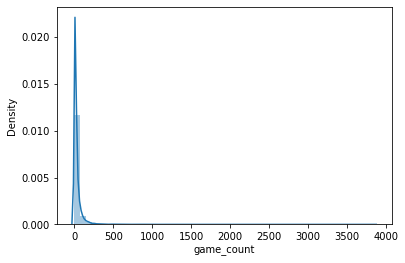

In [ ]:
sns.distplot(user_play_game_df['game_count'])

In [ ]:
user_play_game_df.sort_values(by = 'game_count', ascending=False)

,user_id,game_count
692,76561198030784015,3846
1134,MostOG,3608
1205,5e4,3278
12508,76561198094803808,2597
1133,kanehero,2535
...,...,...
23190,76561198111233137,3
11550,76561198040884966,3
14517,76561198007324801,2
435,tunuko,2


유저가 한 게임의 수를 저장한 데이터 프레임

In [ ]:
user_play_game_df.to_csv(DATA_DIR + 'user_play_game_df_v2.csv', index=False)

In [ ]:
len(user_play_game_li)

30379

# 유저가 플레이한 게임을 시간 순서에 따라 나열한 데이터

In [ ]:
import pickle

# save
with open(DATA_DIR + 'user_play_game_li_data_v2.pickle', 'wb') as f:
    pickle.dump(user_play_game_li, f, pickle.HIGHEST_PROTOCOL)

# load
with open(DATA_DIR + 'user_play_game_li_data_v2.pickle', 'rb') as f:
    data = pickle.load(f)

len(data)

30379


# 컬럼 설명

- content : 리뷰 내용 

- game_id : 게임 키 값

- game_link : 게임을 이용한 유저의 정보를 얻는 웹사이트 링크

- header: 전처리전 해당 리뷰에 대한 사람들의 평가 (유용, 재미)

- playHour : 전처리전 플레이 시간에 대한 정보

- posted_at : 전처리전 리뷰 올린 시간에 대한 정보

- title : 추천 여부

- user_id : 유저 키 값

- clean_playHour : 전처리후 플레이 시간에 대한 정보

- game_content_link : 게임에 대한 메타 정보를 얻는 웹사이트 링크

- timestamp : 라뷰를 등록한 시간 (년 - 월 - 일)

- play_time_minute : 게임을 플레이한 시간 (60분 단위)

- review_time_minute : 리뷰를 달기 위한 게임 플레이 시간 (60분 단위)

- clean_header : 전처리후 해당 리뷰에 대한 사람들의 평가 (유용, 재미)

- review_helpful_coun : 해당 리뷰를 유용하다고 판단한 사람의 수

In [ ]:
df.head()

,content,recommended,user_id,game_id,timestamp,play_time_minute,review_time_minute,game_content_link,review_helpful_count
0,"Very good game, within 6 hours from launch, th...",Recommended,atgbui,768520,2021-06-20,3042.0,3042.0,https://store.steampowered.com/app/768520,5
1,I cannot recommend this game. It's been 8 year...,Not Recommended,atgbui,251570,2021-06-14,40440.0,40440.0,https://store.steampowered.com/app/251570,48
2,Game is currently busted for Co-Op. Despite th...,Not Recommended,atgbui,671510,2021-06-12,1734.0,906.0,https://store.steampowered.com/app/671510,3
3,Unfortunately dead game. https://steamcharts.c...,Not Recommended,atgbui,613590,2021-06-12,48.0,48.0,https://store.steampowered.com/app/613590,0
4,It just felt too generic- why would I play thi...,Not Recommended,atgbui,374280,2021-05-20,540.0,540.0,https://store.steampowered.com/app/374280,1


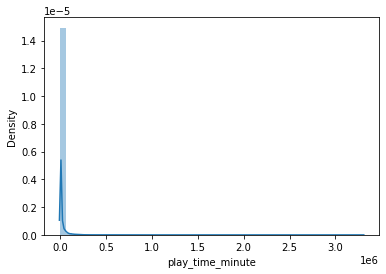

In [ ]:
sns.distplot(df['play_time_minute'])

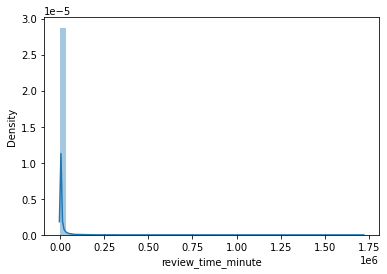

In [ ]:
sns.distplot(df['review_time_minute'])

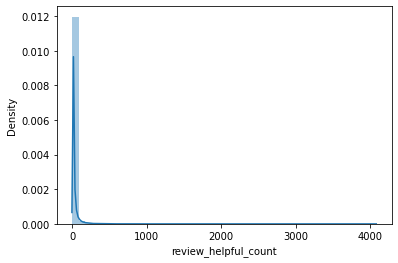

In [ ]:
sns.distplot(df['review_helpful_count'])